In [1]:
import numpy as np
import matplotlib
import scipy.integrate as sint
import matplotlib.pyplot as plt

pi = np.pi




In [2]:
import constants

q = constants.cgs_constants['q']
c = constants.cgs_constants['c']
m_e = constants.cgs_constants['m_e']
m_p = constants.cgs_constants['m_p']



In [3]:
import solvers
import particles
import fields
import analytic_models



# The first part of this is the field solver test 
The order of operations are as follows 
 * Eefine the parameters for the field solver test
 * Initialize the distribuiton 
 * Initializs particles  
 * Solve the fields
 * Postprocessing and plotting

In [ ]:

## Particle definitions 
sigma_x = 0.05
Q = constants.charge_mks_to_cgs(5.0e-9)
n_particles = 5000

## Field solver parameters 
L_0 = 10. * sigma_x ## Half the domain size
L_min = L_0 / 50 ## minimum wavelength to resolve

## Grid definitions for plotting 
x_max = 6 * sigma_x ## Half the plotting region
n_grid = 41
grid_index = int(n_grid / 2.) 



In [ ]:
## This is where we initialize a gaussian distribuiton
distribution = particles.distribution(N = n_particles)
distribution.construct_uniform_guassian_2D(sigma_x = sigma_x, sigma_y=sigma_x)

## Particle distributions
my_gaussian_beam = particles.particles_2D_tent(distribution, 
     dx_tent = 2. * L_min, dy_tent = 2. * L_min,
    bunch_charge = Q, species_mass = m_p)

## Define the fields 
my_fields = fields.cartesian_2D(L_x = L_0, L_y = L_0, L_x_min = L_min, L_y_min = L_min)

## This is where we instantiate the solver
field_solver = solvers.field_solver_2D()




In [ ]:
plt.figure()
plt.hexbin(my_gaussian_beam.x, my_gaussian_beam.y)
plt.show()

In [ ]:
## Compute the potentials at the particle coordinates
field_solver.compute_phi(my_fields, my_gaussian_beam)

## Compute the potentials on a grid
field_solver.compute_phi_mesh(my_fields, xmax = x_max, ymax = x_max, n_grid = n_grid)



In [ ]:
field_solver.compute_kick(my_fields, my_gaussian_beam)

In [ ]:
## post processing and  plotting 


plt.figure()

plt.plot(my_fields.y_grid[:, grid_index] / sigma_x, 
    my_fields.phi_grid[:, grid_index], label = 'tent functions', linewidth = 2.)

plt.legend(loc = 0)
plt.xlabel(r'Position [$\sigma_x$]')
plt.ylabel('Potential [V]')

plt.figure()
plt.imshow(np.real(my_fields.phi_grid))

plt.figure()
plt.plot(my_fields.phi_grid.flatten())
plt.show()

plt.figure()
plt.plot(my_gaussian_beam.x,my_fields.kick_x, 'o')
plt.plot(my_gaussian_beam.y,my_fields.kick_y, 'o')

# Next we test the particle pusher 

The workfow is the following 
* Construct a KV distribution 
* Initialize the kinetics sovler 
* Determine the simulation parameters (number of steps etc)
* Run the simulation 
* Post-process the results 

In [4]:
## Particle definitions 
sigma_x = 0.1
Q_mks = 5.0e-10
Q = constants.charge_mks_to_cgs(Q_mks)

n_particles = 10000
L_0 = 6. * sigma_x ## Half the domain size
L_min = L_0 / 40 ## minimum wavelength to resolve

E = 2.0e6

## This is where we initialize a gaussian distribuiton
new_distribution = particles.distribution(N = n_particles)
new_distribution.construct_kv(r_0 = sigma_x)

## Particle distributions
my_kv_beam = particles.particles_2D_delta(new_distribution,  #dx_tent = L_min, dy_tent = L_min, 
    bunch_charge = Q, species_charge = q, species_mass = m_p, K_e = E)

my_kv_beam_tent = particles.particles_2D_tent(new_distribution, dx_tent = L_min, dy_tent = L_min, 
    bunch_charge = Q, species_charge = q, species_mass = m_p, K_e = E)

## Define the fields 
my_kv_fields = fields.cartesian_2D(L_x = L_0, L_y = L_0,
	L_x_min = L_min, L_y_min = L_min)

r_beam = np.sqrt((my_kv_beam.x)** 2 + (my_kv_beam.y) **2)


In [5]:

## This is where we instantiate the solver
field_solver = solvers.field_solver_2D()

# instantiate the kinetics solver
kinetics_solver = solvers.kinetics_solver_SC2D(ds = 1.0)

# note s is in cm

# compute the potentials at the particles/
field_solver.compute_phi(my_kv_fields, my_kv_beam)
field_solver.compute_psi_particles(my_kv_fields, my_kv_beam)
field_solver.compute_kick(my_kv_fields, my_kv_beam)

/Users/jedelen/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


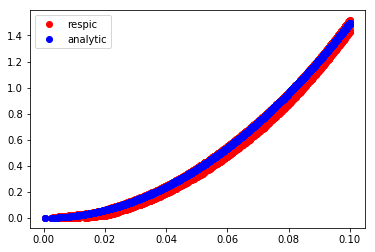

In [6]:

psi_analytic = analytic_models.compute_psi(sigma_x, my_kv_beam)
psi_respic = my_kv_fields.psi_vals - np.min(my_kv_fields.psi_vals)

plt.figure()
plt.plot(r_beam, psi_respic, 'ro', label = 'respic')
plt.plot(r_beam, psi_analytic , 'bo', label = 'analytic')
plt.legend(loc = 0)
plt.show()

# compute the analytic potential and compare with the numerical potential


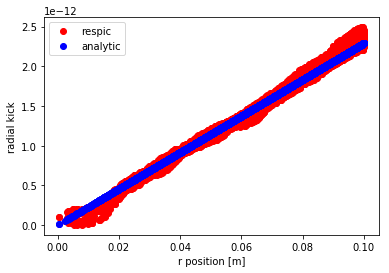

In [7]:
kick_analytic = analytic_models.compute_kick_psi(sigma_x, my_kv_beam)

kick_r = np.sqrt(my_kv_fields.kick_y **2 + my_kv_fields.kick_x **2)

plt.figure()
plt.plot(r_beam, kick_r,'ro', label = 'respic')
plt.plot(r_beam, kick_analytic, 'bo', label = 'analytic')
plt.xlabel('r position [m]')
plt.ylabel('radial kick')
plt.legend(loc = 0)



In [ ]:
## Here we plot a histogram of the particles weighted by the kicks in both planes 
## as well as the radial kick as a function of radial position

plt.figure()
plt.hist2d(my_kv_beam.x, my_kv_beam.y, weights = my_kv_fields.kick_x, bins = 20)
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')

plt.figure()
plt.hist2d(my_kv_beam.x, my_kv_beam.y, weights = my_kv_fields.kick_y, bins = 20)
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')

x0 = np.mean(my_kv_beam.x)
y0 = np.mean(my_kv_beam.y)
r = np.sqrt((my_kv_beam.x  - x0)** 2 + (my_kv_beam.y - y0) **2)
kick_r = np.sqrt(my_kv_fields.kick_y **2 + my_kv_fields.kick_x **2)

plt.figure()
plt.plot(r,kick_r,'o')
plt.xlabel('r position [m]')
plt.ylabel('radial kick')

plt.show()

In [ ]:
r_max = [sigma_x]
k = 0

E0 = np.sum(my_kv_beam.px) + np.sum(my_kv_beam.py)

E = [E0]
while k < 10:

    kinetics_solver.step(my_kv_beam, my_kv_fields, field_solver)
    
    x0 = np.mean(my_kv_beam.x)
    y0 = np.mean(my_kv_beam.y)
    r_beam = np.sqrt((my_kv_beam.x)** 2 + (my_kv_beam.y) **2)
    r_max.append(np.max(r_beam))
    E0 = np.sum(my_kv_beam.px) + np.sum(my_kv_beam.py)

    E.append(E0)
    
    print(k)
    
    k = k + 1

np.save('r_max.npy', r_max)

In [ ]:
## This is the code for the expansion of a round beam in a drift 

def round_beam_expansion(x, r0, q, gamma, m_0):
    
    beta = np.sqrt(1. - 1./ gamma **2)
    
    I = q * beta * c / 100. 
    
    I0 = 4 * pi * 8.85e-12 * (c/100.) ** 3 * (m_0 / 1000.) / (1.602e-19) 
    #I0 = 17000 #31000.
    
    K = I * 2. / (I0 * beta **3 * gamma **3)

    print(I)
    print(I0)
    print(K)
    def func(r,z):
        
        Rpp = K/r[0]
        
        return np.asarray([r[1], Rpp])
    
    r_init = np.asarray([r0, 0])
    
    output = sint.odeint(func, r_init, x)
    
    return output

In [ ]:
k = len(r_max)
x = np.linspace(0,kinetics_solver.ds* k, k)

#x = np.linspace(0,5,1000)

r_analyitic = round_beam_expansion(x / 100. , sigma_x / 100. , Q_mks * 80, my_kv_beam.gamma, my_kv_beam.m_0)


In [ ]:
x = np.linspace(0,kinetics_solver.ds* k, k)

plot_data = np.column_stack([x, np.asarray(E)])
np.save('energy_cons.npy', plot_data)

plt.figure()
plt.plot(x,np.asarray(E))
plt.ylabel(r'$\Sigma_n p_{x,n} + p_{y,n}$')
plt.xlabel(r'Step')
plt.savefig('output.png')
plt.show()


In [ ]:
plt.figure()
plt.plot(x,r_max,linewidth = 1.5, label = 'respic solution')
plt.plot(x,r_analyitic[:,0] * 100, linewidth = 1.5, label = 'analytic solution')
plt.xlabel('s position [cm]')
plt.ylabel('beam radius [cm]')
plt.legend(loc = 0)
plt.grid()

plt.figure()
plt.plot(x,r_max / (r_analyitic[:,0] * 100. ))





In [ ]:
plt.figure(figsize = (6,6))
plt.plot(my_kv_beam.x,my_kv_beam.y, 'o')
plt.show()

In [ ]:
my_kv_beam.weight

In [ ]:
np.max(my_kv_beam.x)

In [ ]:
my_kv_beam.beta

In [ ]:
def compute_momentum_arg(beta, p_xi, px, py, m_0):

    argument = np.sqrt(beta**2 * p_xi **2 - px **2 - py**2 - (m_0)**2 * c**2)
    return argument



gamma = 100.
beta = np.sqrt(1. - 1. / gamma**2)

p_xi = gamma * m_p * c / beta 
print(p_xi)
px = 2.0e-12
py = 0

xp =  - px / (p_xi * beta) * (1 / (beta**2) - 1)


argument = 1. / compute_momentum_arg(beta, p_xi, px, 0, m_p)


relativistic_factor = 1. / (beta ** 2) - 1. 

x_array = []
x0 = 0
#x_array.append(x0)
x = x0
k = 0
ds = 1.0
while k <= 10.:
    
    x += - px * relativistic_factor * argument * ds
    
    x_array.append(x)
    k = k + 1


s = np.linspace(1, k * ds, k)
x2 = x0 + s * xp
plt.figure()
plt.plot(s, x_array)
plt.plot(s, x2)
plt.xlabel('s')

plt.ylabel('x')


plt.show()

In [ ]:
my_kv_beam.gamma
